# Final GEO256:  Temporal Analysis and Prediction of Chlorophyll-a in Balikpapan Bay, Indonesia: A Statistical Approach

# Import Libraries

In [1]:
# Import pygmt for creating maps and processing geospatial data, leveraging the Generic Mapping Tools (GMT).
import pygmt

# Import numpy as np for numerical operations on arrays and matrices, widely used for scientific computing.
import numpy as np

# Import pandas as pd for data manipulation and analysis, particularly useful for handling structured data.
import pandas as pd

# Import pyplot from matplotlib as plt for creating static, interactive, and animated visualizations in Python.
import matplotlib.pyplot as plt

# Import seaborn as sns for statistical data visualization, built on top of matplotlib and closely integrated with pandas data structures.
import seaborn as sns

# From the scipy library, import stats module for a large number of probability distributions and statistical functions.
from scipy import stats

# From statsmodels' tsa.stattools, import adfuller and kpss for statistical tests that can be used to check the stationarity of a time series.
# adfuller: Augmented Dickey-Fuller unit root test.
# kpss: Kwiatkowski-Phillips-Schmidt-Shin test for stationarity.
from statsmodels.tsa.stattools import adfuller, kpss

# From statsmodels' graphics.tsaplots, import plot_acf and plot_pacf for plotting the autocorrelation and partial autocorrelation functions,
# useful in the analysis of time series data.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Import EVA (Extreme Value Analysis), get_extremes, and get_return_periods from pyextremes for analyzing and modeling extreme values in data.
from pyextremes import EVA, get_extremes, get_return_periods

# Import TabularDataset and TabularPredictor from autogluon.tabular for automated machine learning on tabular data.
# TabularDataset: For loading and pre-processing structured data.
# TabularPredictor: For training machine learning models and making predictions.
from autogluon.tabular import TabularDataset, TabularPredictor

# Set the plotting style to 'bmh' (Bayesian Methods for Hackers:  Davidson-Pilon(2015)) using matplotlib. This style is suited for visualizations within
# Bayesian frameworks but is widely applicable for its clean and readable presentation.
plt.style.use("bmh")

In [2]:
# SHUT UP!!!
import shutup; shutup.please()

# Introduction

Balikpapan Bay, situated in East Borneo between Nusantara City and Balikpapan City-Penajam Paseur Utara Regency, stretches over a north-south axis for about 35 km. Its width varies from 1 – 8 km. This semi-enclosed bay is fed by fresh water from Sepaku, Semoi, Wain, and Riko Rivers, while saline water enters from the Makassar Strait [Anwar et al., 2023](http://www.bioflux.com.ro/docs/2023.2349-2368.pdf). See two figures below for a visual representation.

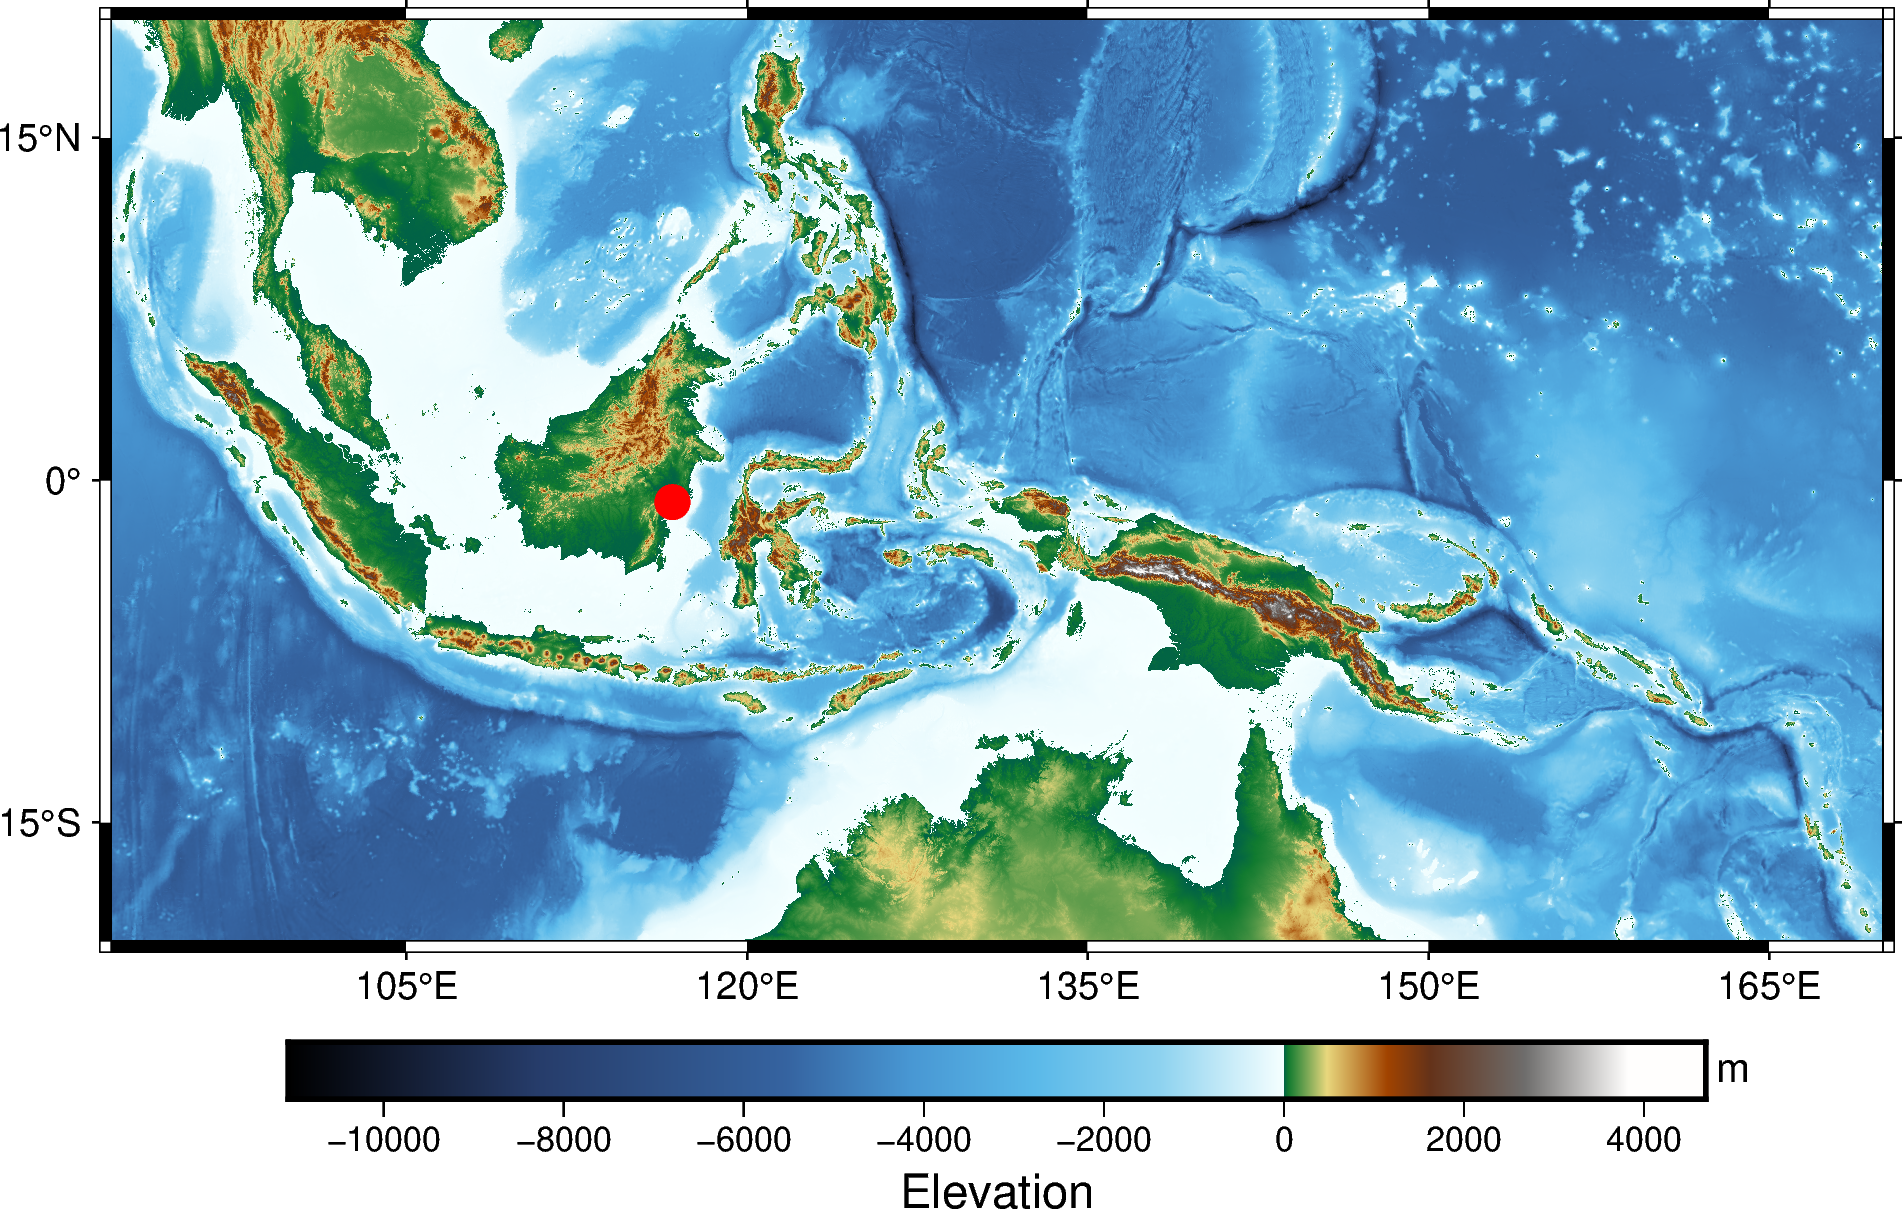

In [3]:
class SRTMMapPlotter:
    """
    A class to encapsulate the process of loading, plotting, and saving SRTM15+ Earth relief data using PyGMT.

    Attributes:
        region (list): The geographical region to plot specified as [west, east, south, north].
        resolution (str): The resolution of the Earth relief data. Default is "15s".
        grid (xarray.DataArray): The loaded Earth relief data for the specified region.
        figure (pygmt.Figure): The PyGMT figure object for plotting.

    Methods:
        load_data(): Loads the Earth relief data based on the specified region and resolution.
        plot_map(): Plots the Earth relief data as a map.
        plot_marker(x, y, style, fill): Marks a specific point on the map.
        add_colorbar(frame): Adds a colorbar to the map.
        show(): Displays the figure in an interactive window.
        save(filename, dpi): Saves the figure to a file with the specified resolution.
    """
    def __init__(self, region, resolution="15s"):
        """
        Initializes the SRTMMapPlotter object with a specified region and resolution.

        Parameters:
            region (list): The geographical region to plot specified as [west, east, south, north].
            resolution (str): The resolution of the Earth relief data. Default is "15s".
        """
        self.region = region
        self.resolution = resolution
        self.grid = self.load_data()
        self.figure = pygmt.Figure()

    def load_data(self):
        """
        Loads the Earth relief data for the specified region and resolution.

        Returns:
            xarray.DataArray: The loaded Earth relief data.
        """
        return pygmt.datasets.load_earth_relief(resolution=self.resolution, region=self.region)

    def plot_map(self):
        """
        Plots the Earth relief data as a map using the loaded grid data.
        """
        self.figure.grdimage(grid=self.grid, projection="M15c", frame="a", cmap="geo")

    def plot_marker(self, x, y, style="c0.3c", fill="red"):
        """
        Marks a specific point on the map with a marker.

        Parameters:
            x (float): The longitude of the point to mark.
            y (float): The latitude of the point to mark.
            style (str): The style of the marker. Default is "c0.3c".
            fill (str): The fill color of the marker. Default is "red".
        """
        self.figure.plot(x=x, y=y, style=style, fill=fill)

    def add_colorbar(self, frame=["a2000", "x+lElevation", "y+lm"]):
        """
        Adds a colorbar to the map to indicate elevation values.

        Parameters:
            frame (list): Customization options for the colorbar. Default shows elevation in meters.
        """
        self.figure.colorbar(frame=frame)

    def show(self):
        """
        Displays the figure in an interactive window.
        """
        self.figure.show()

    def save(self, filename="../figs/fig1.png", dpi=400):
        """
        Saves the figure to a file with the specified resolution.

        Parameters:
            filename (str): The path and name of the file to save the figure.
            dpi (int): The resolution in dots per inch (DPI) for the saved figure. Default is 400.
        """
        self.figure.savefig(filename, dpi=dpi)

# IMC map
if __name__ == "__main__":
    # Initialize the plotter with a specific geographical region
    plotter = SRTMMapPlotter(region=[92, 170, -20, 20])
    # Plot the Earth relief map
    plotter.plot_map()
    # Add a marker to the map
    plotter.plot_marker(x=116.708611, y=-0.973056)
    # Add a colorbar to the map
    plotter.add_colorbar()
    # Display the map
    plotter.show()
    # Save the map to a file
    plotter.save()

Local bathymetry from [Putri et al. (2021)](https://doi.org/10.13170/depik.10.2.19259):

![Balikpapan Bay](../figs/balikpapan.png "my title")

Why so important?

- The Indonesian government intends to relocate its capital from Jakarta to Nusantara, at an estimated cost of $32 billion [(Normile, 2020)](https://www.science.org/content/article/indonesia-s-utopian-new-capital-may-not-be-green-it-looks).

- Balikpapan Bay serves as a key maritime gateway to Indonesia's new capital city, emphasizing its strategic importance for access and development. This geographical feature highlights the connectivity between the sea and urban infrastructure, facilitating transportation and logistics to support the growth and accessibility of the capital.

# Exploratory Data Analysis

In this study, I have harnessed a diverse range of data sources to conduct an in-depth analysis of daily surface chlorophyll-a concentrations, as well as temperature, salinity, river discharge, nutrient levels, solar radiation, and rainfall in the area surrounding Balikpapan Bay, covering the period from 2019 to 2021.

- **Surface Chlorophyll-a Concentrations**: We rely on the comprehensive OCEANCOLOUR_GLO_BGC_L4_MY_009_104 dataset from the Copernicus Marine Environment Monitoring Service. This dataset integrates satellite observations from a variety of sources, including SeaWiFS, MODIS-Aqua and -Terra, MERIS, VIIRS-SNPP, and OLCI-Sentinel 3A & 3B, offering a detailed 4 km x 4 km spatial resolution ([E.U. Copernicus Marine Service Information, 2023b](https://data.marine.copernicus.eu/product/OCEANCOLOUR_GLO_BGC_L4_MY_009_104/description)).

- **Temperature and Salinity Observations**: Daily data for temperature and salinity are obtained using the Hamburg Shelf Ocean Model (HAMSOM) specifically for Balikpapan Bay and its adjacent waters, providing a fine spatial resolution of 0.15 x 0.15 km ([Anwar et al., 2021](https://iopscience.iop.org/article/10.1088/1755-1315/925/1/012013/pdf)).

- **River Discharge Measurements**: The Global Flood Awareness System (GloFAS-ERA5) supplies daily river discharge data with a horizontal resolution of approximately 11.1 km. This includes discharge from the principal rivers in Balikpapan Bay: Sepaku, Semoi, Wain, and Riko ([Harrigan et al., 2020](https://essd.copernicus.org/articles/12/2043/2020/)).

- **Nutrient and Dissolved Oxygen Levels**: The GLOBAL_ANALYSIS_FORECAST_BIO_001_028 from the Global Ocean Biogeochemistry Analysis and Forecast provides daily updates on nitrate, phosphate, silicate, and dissolved oxygen with a resolution of 0.25° x 0.25° ([E.U. Copernicus Marine Service Information, 2023a](https://cis2.eea.europa.eu/product/137/)).

- **Solar Radiation Data**: Utilizing hourly ERA5 data, we obtain daily solar radiation figures with a spatial resolution of approximately 27 km ([Hersbach et al., 2023](https://www.copernicus.eu/en/access-data/copernicus-services-catalogue/reanalysis-era5-single-levels)).

- **Precipitation Records**: Daily rainfall data is sourced from BMKG Sepinggan, Balikpapan, through the Pusat Database BMKG, ensuring accurate precipitation measurements for our study area ([BMKG, 2023](https://dataonline.bmkg.go.id/)).

This comprehensive dataset selection spans an area between 1.5S - 1S and 116.5E - 117E and has been previously utilized in related studies, validating its applicability and reliability for our research objectives ([Anwar et al., 2023](http://www.bioflux.com.ro/docs/2023.2349-2368.pdf)).

## Read Data

In [4]:
df = pd.read_csv("../data/all_data.csv", index_col="Date",
                parse_dates=True)

In [5]:
print(df.head())

            Chlorophyll_a   Nitrate  Phosphate  Silicate  Dissolved_Oxygen  \
Date                                                                         
2019-01-01           1.39  0.388450   0.001513  9.791618        201.420494   
2019-01-02           1.90  0.235056   0.001080  8.510964        201.230118   
2019-01-03           1.89  0.188044   0.001179  8.200518        201.149078   
2019-01-04           1.68  0.155607   0.001050  8.054524        201.072983   
2019-01-05           1.39  0.154504   0.001147  8.111265        201.004051   

            Total_River_Discharge  Rainfall  Temperature   Salinity  \
Date                                                                  
2019-01-01              92.373733       0.0    31.243146  33.284887   
2019-01-02             151.474331      12.8    30.575972  32.932942   
2019-01-03             167.575625       1.5    29.944068  32.838706   
2019-01-04             141.435395      54.0    29.590075  32.599721   
2019-01-05             115.

In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1096 entries, 2019-01-01 to 2021-12-31
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Chlorophyll_a          1096 non-null   float64
 1   Nitrate                1096 non-null   float64
 2   Phosphate              1096 non-null   float64
 3   Silicate               1096 non-null   float64
 4   Dissolved_Oxygen       1096 non-null   float64
 5   Total_River_Discharge  1096 non-null   float64
 6   Rainfall               1096 non-null   float64
 7   Temperature            1096 non-null   float64
 8   Salinity               1096 non-null   float64
 9   Solar_Radiation        1096 non-null   float64
dtypes: float64(10)
memory usage: 94.2 KB
None


In [7]:
print(df.describe())

       Chlorophyll_a      Nitrate    Phosphate     Silicate  Dissolved_Oxygen  \
count    1096.000000  1096.000000  1096.000000  1096.000000       1096.000000   
mean        1.756898     0.507450     0.020163    12.016882        204.868132   
std         1.099418     0.737098     0.022469     8.835000          6.014129   
min         0.350000     0.007469     0.000189     3.495606        195.911545   
25%         1.000000     0.026940     0.003154     5.038887        201.106545   
50%         1.510000     0.137631     0.008718     8.452248        202.189230   
75%         2.180000     0.700852     0.039026    16.152503        207.026505   
max        11.270000     3.348402     0.081026    40.316134        229.375118   

       Total_River_Discharge     Rainfall  Temperature     Salinity  \
count            1096.000000  1096.000000  1096.000000  1096.000000   
mean              214.299935     8.576825    29.224334    29.704912   
std               130.865359    18.006769     0.407383   

## Annual Cycle

In [8]:
class SeasonalPlotter:
    """
    A utility class for plotting seasonal trends in a pandas DataFrame. 
    This class is designed to help visualize monthly trends in data over time.
    """

    def __init__(self, dataframe):
        """
        Initializes the SeasonalPlotter with a pandas DataFrame.

        Parameters:
        - dataframe: pandas DataFrame containing the data to be analyzed and plotted.
        """
        try:
            self.dataframe = dataframe
            dataframe.head()  # Try accessing the DataFrame to ensure it's valid.
        except Exception as e:
            print(f"Initialization failed: {e}")
            raise ValueError("Invalid DataFrame provided.") from e

    def plot_seasonal_monthly(self, column_name, title, x_label, y_label, color, save_path=None, dpi=300):
        """
        Plots the monthly seasonal trend of a specified column from the DataFrame.

        Parameters:
        - column_name: The name of the column to analyze and plot.
        - title: The title of the plot.
        - x_label: Label for the x-axis.
        - y_label: Label for the y-axis.
        - color: Color of the bars in the barplot.
        - save_path (optional): The file path to save the plot image. If None, the plot is not saved.
        - dpi (optional): The resolution of the saved plot image. Defaults to 300 DPI.
        
        This method prints out the month with the minimum and maximum average values of the specified column 
        and generates a bar plot showing the average value of the specified column for each month to identify seasonal trends.
        """
        try:
            # Ensure the column exists
            if column_name not in self.dataframe.columns:
                raise ValueError(f"Column '{column_name}' not found in DataFrame.")

            # Resample to monthly averages
            monthly_avg = self.dataframe[column_name].resample('M').mean()
            
            # Create a DataFrame for plotting, including a 'Month' column for the x-axis
            plot_data = pd.DataFrame({column_name: monthly_avg})
            plot_data['Month'] = plot_data.index.month  # Extract month for seasonal plotting
            
            # Group by month to calculate the average value for each month
            seasonal_trends = plot_data.groupby('Month')[column_name].mean()
            
            # Find and print the min and max monthly averages
            min_month = seasonal_trends.idxmin()
            max_month = seasonal_trends.idxmax()
            print(f"Month with minimum average value: {min_month} ({seasonal_trends.min():.2f})")
            print(f"Month with maximum average value: {max_month} ({seasonal_trends.max():.2f})")
            
            # Plotting
            plt.figure(figsize=(10, 6))
            sns.barplot(x=seasonal_trends.index, y=seasonal_trends, color=color)
            plt.title(title)
            plt.xlabel(x_label, fontsize=15)
            plt.ylabel(y_label, fontsize=15)
            plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
            
            # Save the figure if a save path is provided
            if save_path:
                plt.savefig(save_path, dpi=dpi)
                print(f"Figure saved to {save_path} at {dpi} DPI.")
            
            plt.show()
        except Exception as e:
            print(f"Failed to plot seasonal monthly trends: {e}")

In [9]:
season_plot = SeasonalPlotter(df)

Month with minimum average value: 7 (1.34)
Month with maximum average value: 5 (2.11)
Figure saved to ../figs/fig2b.png at 400 DPI.


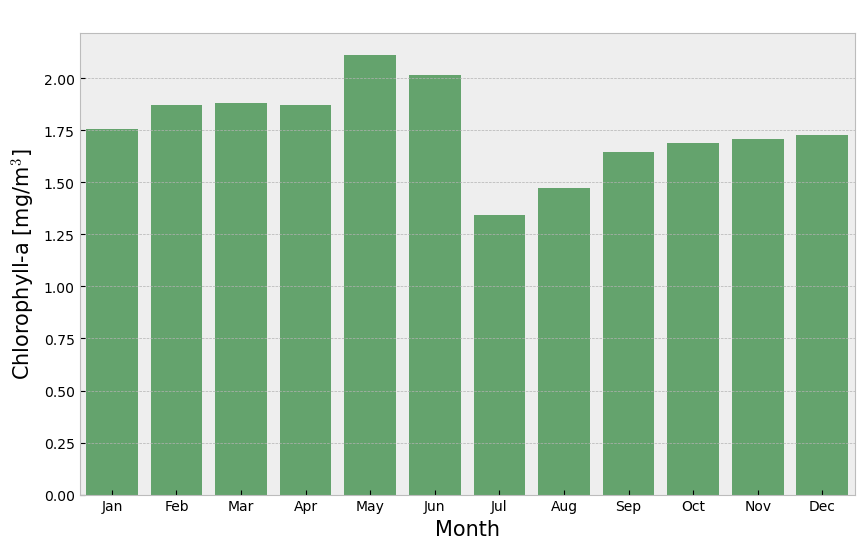

In [10]:
season_plot.plot_seasonal_monthly(
    column_name='Chlorophyll_a', 
    title=' ', 
    x_label='Month', 
    y_label='Chlorophyll-a [mg/m$^3$]',
    color='#5aad65',
    save_path='../figs/fig2b.png',
    dpi=400
)

## Univariate Time-Series Analyses

In [11]:
chl = df["Chlorophyll_a"]

In [12]:
chl.head()

Date
2019-01-01    1.39
2019-01-02    1.90
2019-01-03    1.89
2019-01-04    1.68
2019-01-05    1.39
Name: Chlorophyll_a, dtype: float64

In [13]:
print(chl.info())

<class 'pandas.core.series.Series'>
DatetimeIndex: 1096 entries, 2019-01-01 to 2021-12-31
Series name: Chlorophyll_a
Non-Null Count  Dtype  
--------------  -----  
1096 non-null   float64
dtypes: float64(1)
memory usage: 17.1 KB
None


In [14]:
print(chl.describe())

count    1096.000000
mean        1.756898
std         1.099418
min         0.350000
25%         1.000000
50%         1.510000
75%         2.180000
max        11.270000
Name: Chlorophyll_a, dtype: float64


In [15]:
# HABs events
top_two = chl.nlargest(2)
print("The two maximum Chlorophyll_a values and their dates are:")
for date, value in top_two.items():
    print(f"{value} mg/m^3 on {date.date()}")

The two maximum Chlorophyll_a values and their dates are:
11.27 mg/m^3 on 2020-06-16
10.43 mg/m^3 on 2019-11-09


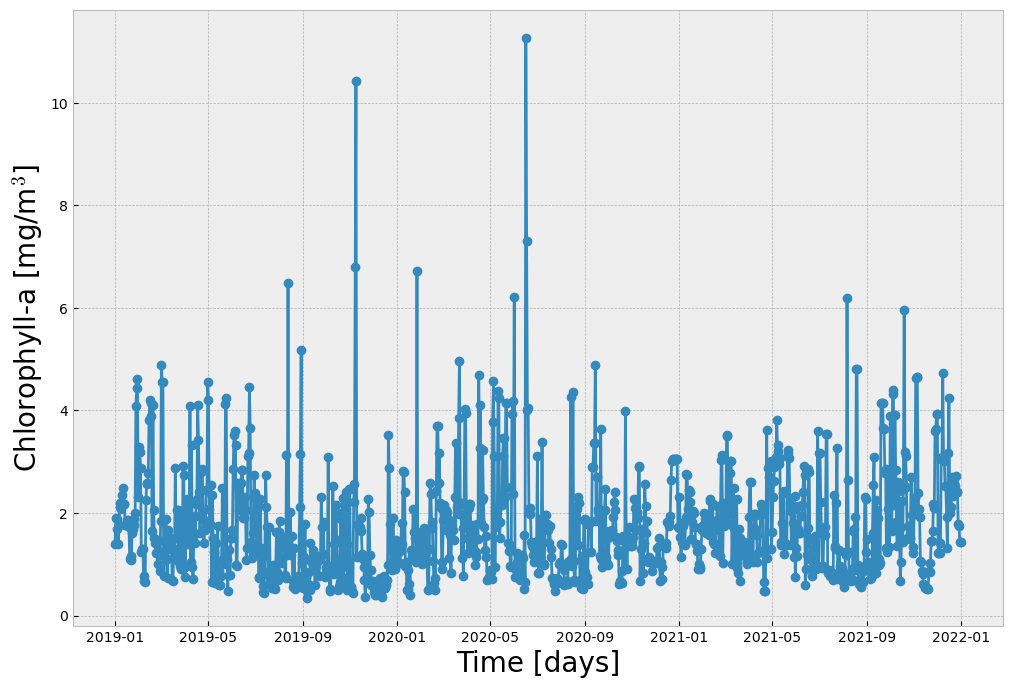

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(chl.index, chl.values, marker="o")  
ax.set_xlabel("Time [days]", fontsize=20)
ax.set_ylabel("Chlorophyll-a [mg/m$^3$]", fontsize=20)
plt.savefig('../figs/fig2a.png', dpi=400)
plt.show()

In [17]:
# HABs events
top_two = chl.nlargest(2)
print("The two maximum Chlorophyll_a concentrations:")
for date, value in top_two.items():
    print(f"{value} mg/m^3 on {date.date()}")

The two maximum Chlorophyll_a concentrations:
11.27 mg/m^3 on 2020-06-16
10.43 mg/m^3 on 2019-11-09


#### 1. Skewness

Skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable.The equation for skewness is:

$$\text{Skewness} = \frac{n}{(n-1)(n-2)} \sum \left(\frac{X_i - \overline{X}}{s}\right)^3 $$

, where $n$ is the sample size, $X_i$ is each individual sample, $\overline{X}$ is the sample mean, and $s$ is the sample standard deviation.

**Interpretation**:
  - A skewness value > 0 means the distribution is skewed to the right (positive skew).
  - A skewness value < 0 means the distribution is skewed to the left (negative skew).
  - A skewness value = 0 indicates a symmetric distribution.


#### 2. Kurtosis

Kurtosis is a measure of the "tailedness" of the probability distribution of a real-valued random variable. The equation for kurtosis is:

$$\text{Kurtosis} = \frac{n(n+1)}{(n-1)(n-2)(n-3)} \sum \left(\frac{X_i - \overline{X}}{s}\right)^4 - \frac{3(n-1)^2}{(n-2)(n-3)} $$

, where $n$, $X_i$, $\overline{X}$, and $s$ have the same meanings as in the skewness formula.


**Interpretation**:
  - A kurtosis value > 0 (or technically speaking, a kurtosis excess > 0) indicates a distribution with heavier tails and a sharper peak compared to a normal distribution (leptokurtic).
  - A kurtosis value < 0 indicates a distribution with lighter tails and a flatter peak compared to a normal distribution (platykurtic).


#### 3. Shapiro-Wilk Test

The Shapiro-Wilk test assesses the normality of a distribution. The test statistic is calculated as follows, which is more complex and its detailed equation involves weights derived from the covariance matrix of the order statistics of a normal distribution:

$$W = \frac{(\sum_{i=1}^{n} a_i x_{(i)})^2}{\sum_{i=1}^{n} (x_i - \overline{x})^2}$$

, where $x_{(i)}$ are the ordered sample values and $a_i$ are constants generated from the means, variances, and covariances of the order statistics of a sample from a normal distribution.

**Interpretation**:
  - A low p-value (< 0.05) indicates the data does not follow a normal distribution.
  - A high p-value (≥ 0.05) suggests the data follows a normal distribution.



#### 4. D’Agostino’s K² Test

The K² statistic is a combination of the z-scores for skewness and kurtosis. It assesses the normality of a dataset by examining the shape of its distribution:

   $$K^2 = Z^2_{\text{skewness}} + Z^2_{\text{kurtosis}}$$

, where:
   - $Z_{\text{skewness}}$ is the z-score of skewness, which quantifies how asymmetrical the distribution is relative to a normal distribution.
   - $Z_{\text{kurtosis}}$ is the z-score of kurtosis, which quantifies how the "tailedness" or peak of the distribution compares to a normal distribution.

This combined statistic, $K^2$, is then compared to critical values from the chi-square distribution to determine the p-value, which indicates whether the data significantly deviate from normality.

**Interpretation**:
- A **low p-value** $(< 0.05)$ suggests that the data do not follow a normal distribution, thereby rejecting the null hypothesis of normality.
- A **high p-value** ($\geq 0.05$) indicates that there is not enough evidence to reject the null hypothesis, suggesting that the data could be considered normally distributed.


#### 5. Augmented Dickey-Fuller (ADF) Test
The ADF test statistic is calculated as:

$$ \text{ADF Statistic} = \frac{\hat{\gamma}}{\text{SE}(\hat{\gamma})} $$

, where $\hat{\gamma}$ is the estimate of the autoregressive coefficient in the model:0
$\Delta y_t = \alpha + \beta t + \gamma y_{t-1} + \sum_{i=1}^{p} \phi_i \Delta y_{t-i} + \epsilon_t$ , and SE$(\hat{\gamma})$ is the standard error of the estimated coefficient.

**Interpretation**:
  - A p-value < 0.05 suggests the series is stationary.
  - A p-value ≥ 0.05 suggests the series is not stationary.


#### 6. Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)

- **ACF** is a measure of the correlation between observations of a time series separated by $k$ periods, with the equation for each lag $k$ being:
  
$$ R(k) = \frac{\sum_{t=1}^{n-k} (X_t - \overline{X})(X_{t+k} - \overline{X})}{\sum_{t=1}^{n} (X_t - \overline{X})^2} $$

- **PACF** measures the partial correlation of a time series with its own lagged values, controlling for the values of the time series at all shorter lags. The calculation of PACF involves solving a series of linear equations (the Yule-Walker equations).

**Interpretation of ACF and PACF**:
  - These functions help in identifying the order of autoregressive (AR) and moving average (MA) processes in time series modeling.

#### 7. Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test

The KPSS test is designed to test for stationarity in a time series. Unlike tests that focus on the presence of a unit root to determine non-stationarity, the KPSS test assumes the null hypothesis that the series is stationary around a deterministic trend. Here is a breakdown of the KPSS test computation and its interpretation:

**Computation**

1. **Regression Model**: First, we model the observed time series \(Y_t\) using a regression that may include a constant and a trend:

   $$ Y_t = \mu + \tau t + \epsilon_t$$

, where $Y_t$ is the value of the series at time $t$, $\mu$ is the intercept, $\tau$ is the trend coefficient, $t$ is the time trend, and $\epsilon_t$ is the residual at time $t$.

2. **Residuals**: The residuals from this regression, $\epsilon_t$, represent the part of $Y_t$ not explained by the trend.

3. **Cumulative Sum of Residuals**: The cumulative sum of residuals is calculated as:

   $$S_t = \sum_{i=1}^{t} \epsilon_i$$

4. **KPSS Statistic**: The test statistic is then computed using the cumulative sum of residuals:
   $$\text{KPSS} = \frac{\sum_{t=1}^{T}S_t^2}{T^2\sigma^2}$$

, where $T$ is the total number of observations, $S_t$ is the cumulative sum of residuals up to time $t$, and $\sigma^2$ is an estimate of the long-run variance of $\epsilon_t$.

**Interpretation**

- **p-value ≥ 0.05**: If the p-value is greater than or equal to 0.05, we fail to reject the null hypothesis, suggesting that the series is stationary around a deterministic trend. This means that any movement in the series can be attributed to a long-term trend rather than stochastic or random processes.

- **p-value < 0.05**: If the p-value is less than 0.05, we reject the null hypothesis, indicating that the series is not stationary. This suggests that the series has a unit root, and its properties depend on the time at which it is observed, implying that the series may exhibit random walks or trends that are not predictable over time.

The KPSS test thus provides a method to assess whether a time series is characterized by stationary fluctuations around a deterministic trend or whether it shows signs of non-stationarity, which would necessitate differencing or other transformations to achieve stationarity for further analysis or modeling.

In [18]:
class TimeSeriesAnalysis:
    def __init__(self, series: pd.Series):
        """
        Initialize the TimeSeriesAnalysis with a Pandas Series.
        
        :param series: Pandas Series containing the time series data.
        """
        self.series = series

    def print_skewness_kurtosis(self) -> None:
        """
        Calculate and print skewness and kurtosis of the series.
        """
        try:
            skewness = stats.skew(self.series)
            kurtosis = stats.kurtosis(self.series)
            print(f"\nSkewness: {round(skewness, 3)}\nKurtosis: {round(kurtosis, 3)}")
            print("Interpretation: ", end="")
            print("The distribution is " + ("symmetric." if skewness == 0 else "skewed."))
            print("The distribution has " + ("less " if kurtosis < 0 else "excess ") + "kurtosis compared to a normal distribution.")
        except Exception as e:
            print(f"An error occurred while calculating skewness and kurtosis: {e}")
            
    def interpret_normality_tests(self) -> None:
        """
        Perform and interpret Shapiro-Wilk and D'Agostino's K^2 normality tests.
        """
        try:
            print("Normality Tests Interpretation:")
            shapiro_stat, shapiro_p = stats.shapiro(self.series)
            print(f"Shapiro-Wilk Test: Statistic={round(shapiro_stat, 3)}, p-value={round(shapiro_p, 3)}. " +
                  ("Data is not normally distributed." if shapiro_p < 0.05 else "Data follows a normal distribution."))
            
            dagostino_stat, dagostino_p = stats.normaltest(self.series)
            print(f"D’Agostino’s K^2 Test: Statistic={round(dagostino_stat, 3)}, p-value={round(dagostino_p, 3)}. " +
                  ("Data is not normally distributed." if dagostino_p < 0.05 else "Data follows a normal distribution."))
        except Exception as e:
            print(f"An error occurred during normality tests: {e}")

    def interpret_stationarity_tests(self) -> None:
        """
        Perform and interpret ADF and KPSS stationarity tests.
        """
        try:
            print("\nStationarity Tests Interpretation:")
            adf_result = adfuller(self.series, autolag='AIC')
            adf_stat, adf_p = adf_result[0], adf_result[1]
            print(f"ADF Test: Statistic={round(adf_stat, 3)}, p-value={round(adf_p, 3)}. " +
                  ("Series is stationary." if adf_p < 0.05 else "Series is not stationary."))
            
            kpss_result = kpss(self.series, regression='c')
            kpss_stat, kpss_p = kpss_result[0], kpss_result[1]
            print(f"KPSS Test: Statistic={round(kpss_stat, 3)}, p-value={round(kpss_p, 3)}. " +
                  ("Series is stationary." if kpss_p >= 0.05 else "Series is not stationary."))
        except Exception as e:
            print(f"An error occurred during stationarity tests: {e}")

    def plot_distribution_with_kde(self, filename: str = '../figs/fig2c.png') -> None:
        """
        Plot the distribution of the series with KDE and save to a file.
        Additionally, shows the plot.
        
        :param filename: Filename to save the plot.
        """
        try:
            fig, ax = plt.subplots(figsize=(12, 8))
            sns.histplot(self.series, kde=True, bins=15, ax=ax)
            ax.set_xlabel('Chlorophyll-a [mg/m$^3$]', fontsize=20)
            ax.set_ylabel('Probability Density', fontsize=20)
            plt.savefig(filename)
            plt.show()
            plt.close()
        except Exception as e:
            print(f"An error occurred while generating the KDE plot: {e}")

    def plot_acf_pacf(self, filename: str = '../figs/fig2d.png') -> None:
        """
        Plot ACF and PACF and save to a file. Additionally, shows the plot.
        
        :param filename: Filename to save the plot.
        """
        try:
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), dpi=100)
            plot_acf(self.series, ax=ax1, lags=30)
            ax1.set_title("Autocorrelation Function", fontsize=16)
            ax1.set_xlabel("Lags")
            ax1.set_ylabel("Autocorrelation")
            
            plot_pacf(self.series, ax=ax2, lags=30)
            ax2.set_title("Partial Autocorrelation Function", fontsize=16)
            ax2.set_xlabel("Lags")
            ax2.set_ylabel("Partial Autocorrelation")
            
            plt.tight_layout()  # Adjust layout to prevent overlap
            plt.savefig(filename)
            plt.show()
            plt.close()
        except Exception as e:
            print(f"An error occurred while generating ACF and PACF plots: {e}")

In [19]:
analysis = TimeSeriesAnalysis(chl)

In [20]:
analysis.print_skewness_kurtosis()


Skewness: 2.212
Kurtosis: 10.16
Interpretation: The distribution is skewed.
The distribution has excess kurtosis compared to a normal distribution.


In [21]:
analysis.interpret_normality_tests()

Normality Tests Interpretation:
Shapiro-Wilk Test: Statistic=0.84, p-value=0.0. Data is not normally distributed.
D’Agostino’s K^2 Test: Statistic=574.189, p-value=0.0. Data is not normally distributed.


In [22]:
analysis.interpret_normality_tests()

Normality Tests Interpretation:
Shapiro-Wilk Test: Statistic=0.84, p-value=0.0. Data is not normally distributed.
D’Agostino’s K^2 Test: Statistic=574.189, p-value=0.0. Data is not normally distributed.


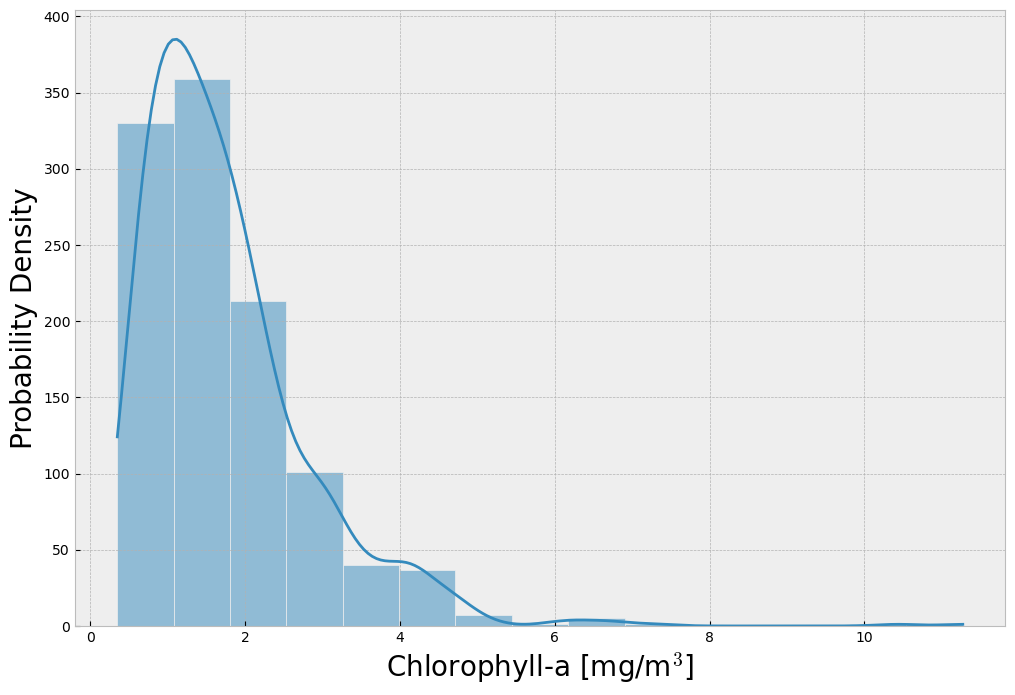

In [23]:
analysis.plot_distribution_with_kde()

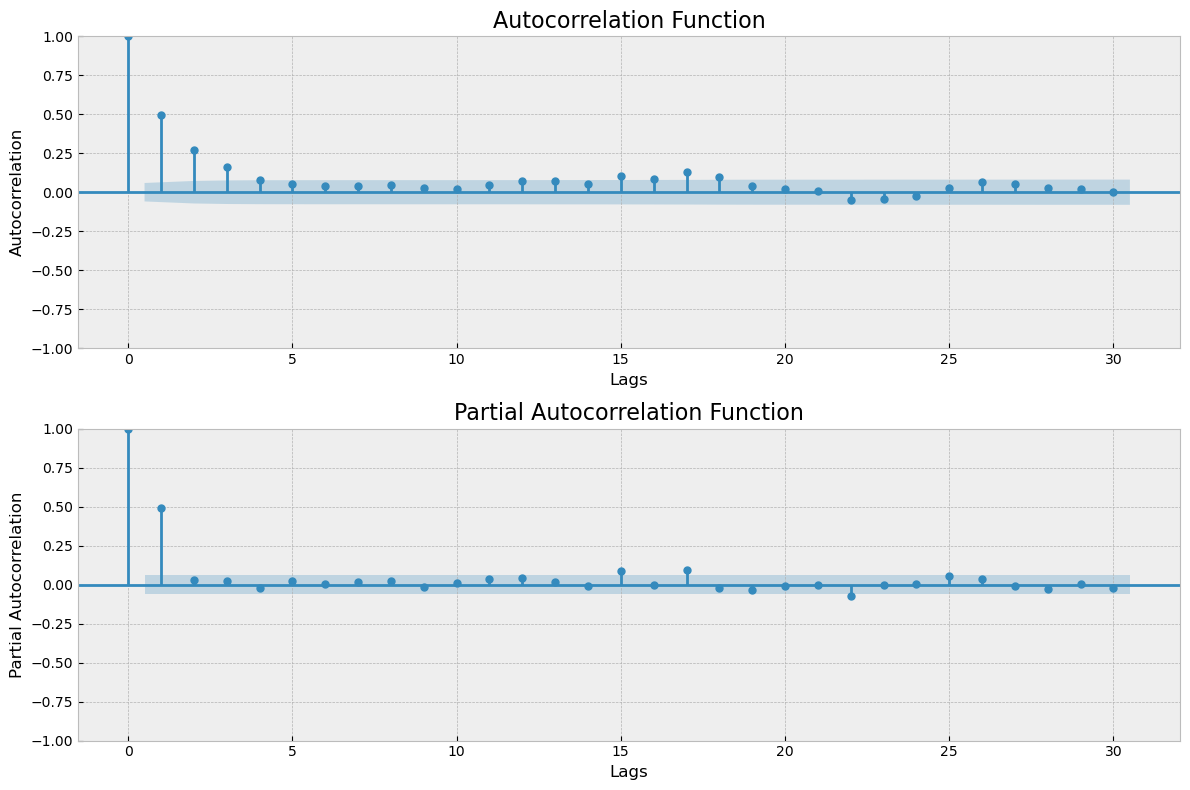

In [24]:
analysis.plot_acf_pacf()

1. **ACF Plot Interpretation:**
   - The ACF shows a strong autocorrelation at lag 0, which is always the case since a data point is perfectly correlated with itself.
   - The sharp drop from lag 0 to lag 1 and the subsequent lags settling within the confidence interval (typically represented by the blue shaded area) suggest that there is no significant autocorrelation at lags greater than 0. This can imply that the data is not an autoregressive process or that the autoregressive effect is minimal.

2. **PACF Plot Interpretation:**
   - The PACF shows a significant spike at lag 1, and possibly at lag 2, which suggests a possible AR(1) or AR(2) model could be fitted to the data. An AR(1) model implies that the current value is significantly correlated with the immediate previous value, while an AR(2) model would extend this correlation to the value two time points prior.
   - The subsequent lags are within the confidence interval, suggesting no further significant partial autocorrelations.

3. **Combined ACF and PACF Interpretation:**
   - Given the significant spike in the PACF at lag 1 (and possibly at lag 2) and the rapid decline in the ACF, the data may be well represented by a low-order AR model.
   - The lack of a gradual decay in the ACF plot suggests that a differencing step (common in ARIMA modeling) may not be necessary for this particular time series.
   - Since the ACF does not show a pattern of significant lags, it is unlikely that a Moving Average (MA) process is present.

4. **Modeling Implication:**
   - Based on the ACF and PACF plots, an AR(1) or AR(2) model could be a good starting point for modeling this time series data. Further analysis, such as checking for stationarity and performing model fitting, would be needed to confirm this.

In [25]:
analysis.interpret_stationarity_tests()


Stationarity Tests Interpretation:
ADF Test: Statistic=-19.226, p-value=0.0. Series is stationary.
KPSS Test: Statistic=0.298, p-value=0.1. Series is stationary.


# Extreme Value Analysis

#### 1. Extreme Value Analysis (EVA) using Block Maxima (BM)

1. **Block Maxima Extraction**:
   - Data is segmented into blocks of size \( n \), and for each block, the maximum value $M_i$ is selected.
   - $M_i = \max(X_{(i-1)\cdot n+1}, \ldots, X_{in}) $ for $i = 1, \ldots, k $, where $X_j$ represents the chlorophyll-a concentration at the $j^{th}$ observation, $ n $ is the block size, and $k$ is the total number of blocks.

2. **Fitting an Extreme Value Distribution**:
   - The Generalized Extreme Value (GEV) distribution is often fitted to $M$, the set of block maxima, characterized by location ($ \mu $), scale ($ \sigma $), and shape ($ \xi $) parameters.


#### 2. Markov Chain Monte Carlo (MCMC) for Parameter Estimation

1. **Parameter Estimation**:
   - The parameters of the GEV distribution ($\mu, \sigma, \xi$) are estimated using MCMC, specifically the Emcee algorithm, which is designed to sample from the posterior distribution of the parameters given the data.

2. **Bayesian Inference**:
   - Bayesian inference updates prior beliefs about parameters with evidence from the data to form a posterior distribution.
   - The posterior distribution $P(\theta | X)$ is proportional to the likelihood of the data given the parameters $P(X | \theta)$ times the prior distribution of the parameters $P(\theta)$:
     $$P(\theta | X) \propto P(X | \theta) \cdot P(\theta)$$
   - $\theta = (\mu, \sigma, \xi)$ represents the parameters of the GEV distribution, and $X$ represents the observed block maxima.



#### 3. Return Period Calculation

1. **Definition**:
   - The return period $T$ for an event of magnitude $x$ or greater is the reciprocal of the exceedance probability.
   - $T(x) = \frac{1}{1 - F(x)}$, where $F(x)$ is the CDF of the GEV distribution for the block maxima.

2. **Exceedance Probability**:
   - The probability that a given event magnitude $x$ is exceeded is $1 - F(x)$.
   - Thus, the return period can also be understood as the average interval between exceedances of magnitude $x$ or greater.

3. **GEV Cumulative Distribution Function**:
   - For the GEV distribution, the CDF $F(x; \mu, \sigma, \xi)$ is given by:
     $$
     F(x; \mu, \sigma, \xi) = 
     \begin{cases}
     \exp\left(-\left[1 + \xi\left(\frac{x - \mu}{\sigma}\right)\right]^{-1/\xi}\right) & \text{if } \xi \neq 0 \\
     \exp\left(-\exp\left(-\frac{x - \mu}{\sigma}\right)\right) & \text{if } \xi = 0
     \end{cases}
     $$
   - This function is used to calculate the probability of exceedance for a given event magnitude $x$.

In [26]:
class ExtChlorophyllModel:
    """
    A class to model and analyze extreme chlorophyll-a concentrations using Event Analysis.
$32 billion 
    Attributes:
        data (DataFrame): The dataset containing chlorophyll-a concentrations.
        model (EVA object): The extreme value analysis model object.
        summary_bm (DataFrame): Summary of block maxima and return periods.
        extremes (DataFrame): Identified extreme events.
        return_periods (DataFrame): Calculated return periods for extreme events.
    """

    def __init__(self, data):
        """
        Initializes the ExtChlorophyllModel with chlorophyll-a data.

        Parameters:
            data (DataFrame): The dataset containing chlorophyll-a concentrations.
        """
        self.data = data
        self.model = None
        self.summary_bm = None
        self.extremes = None
        self.return_periods = None

    def specify_model(self, block_size="14D"):
        """
        Specifies the extreme value analysis model with given parameters.

        Parameters:
            block_size (str): The size of the block for block maxima method. Defaults to "14D".
        """
        try:
            # Assuming EVA and get_extremes are defined elsewhere
            self.model = EVA(data=self.data)
            self.model.get_extremes(method="BM", extremes_type="high", block_size=block_size, errors="ignore")
        except Exception as e:
            print(f"Error specifying model: {e}")

    def fit_and_plot_model(self):
        """
        Fits the specified model using the Emcee sampler, prints the model summary,
        and plots the extremes and the Markov Chain Monte Carlo (MCMC) traces.
        """
        try:
            # Fit model
            self.model.fit_model(model='Emcee', n_walkers=500, n_samples=2500)
            print(self.model)
            
            # Plot Block Maxima
            fig, ax = self.model.plot_extremes(figsize=(12, 8))
            ax.set_xlabel('Time [days]', fontsize=20)
            ax.set_ylabel('Chlorophyll-a [mg/m$^3$]', fontsize=20)
            fig.tight_layout()
            plt.show()  # Display the figure
            fig.savefig('../figs/fig3a.png', dpi=400)  # Save the figure

            # Plot MCMC trace figures
            fig, ax = self.model.plot_trace(figsize=(15, 8))
            fig.tight_layout()
            plt.show()
            fig.savefig('../figs/fig3b.png', dpi=400)

            fig, ax = self.model.plot_corner(figsize=(15, 15), levels=10)
            fig.tight_layout()
            plt.show()# plot map
            fig.savefig('../figs/fig3c.png', dpi=400)
        except Exception as e:
            print(f"Error fitting and plotting model: {e}")

    def summarize_and_save(self):
        """
        Generates a summary of block maxima and return periods, and saves it to CSV.
        Additionally, computes and saves extreme event return periods.
        """
        try:
            self.summary_bm = self.model.get_summary(return_period=[1, 2, 5, 10, 25, 50, 100, 250, 500, 1000],
                                                     alpha=0.95, n_samples=1000)
            self.summary_bm.to_csv('../data/bm_rp_sum.csv')
            
            self.extremes = get_extremes(ts=self.data, method="BM", block_size="14D")
            self.return_periods = get_return_periods(ts=self.data, extremes=self.extremes, extremes_method="BM", 
                                                     extremes_type="high", block_size="14D",
                                                     return_period_size="14D", plotting_position="weibull")

            rp = self.return_periods.sort_values("return period", ascending=False)
            rp.to_csv('../data/high_return_periods.csv')

            print(rp.sort_values("return period", ascending=False).head())  # Display 5 most extreme cases
        except Exception as e:
            print(f"Error summarizing and saving data: {e}")

    def plot_diagnostic_figures(self):
        """
        Plots diagnostic figures for the extreme value analysis, including return period plots,
        probability density functions, and Q-Q plots.
        """
        try:
            fig, ax = self.model.plot_diagnostic(alpha=0.95, figsize=(18,12))

            # Adjusting figure aesthetics for readability
            for a in fig.axes:
                a.set_title(' ')
            fig.axes[0].set_xlabel('Return Period', fontsize=20)
            fig.axes[0].set_ylabel('Chlorophyll-a [mg/m$^3$]', fontsize=20)
            fig.axes[1].set_xlabel('Chlorophyll-a [mg/m$^3$]', fontsize=20)
            fig.axes[1].set_ylabel('Probability Density', fontsize=20)
            fig.axes[2].set_xlabel('Theoretical', fontsize=20)
            fig.axes[2].set_ylabel('Observed', fontsize=20)
            fig.axes[3].set_xlabel('Theoretical', fontsize=20)
            fig.axes[3].set_ylabel('Observed', fontsize=20)

            sns.despine(left=True)
            plt.show()
            fig.savefig('../figs/fig3d.png')
        except Exception as e:
            print(f"Error plotting diagnostic figures: {e}")

In [27]:
ext_chl_model = ExtChlorophyllModel(data=chl)

In [28]:
# Initialize the model with the dataset
ext_chl_model = ExtChlorophyllModel(data=chl)

In [29]:
# Specify the model with desired parameters
ext_chl_model.specify_model(block_size="14D")

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                 Chlorophyll_a      Size:                               1,096
Start:                       January 2019      End:                        December 2021
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                 79      Extraction method:                     BM
Type:                                high      Block size:              14 days 00:00:00
                                         Model                                          
----------------------------------------------------------------------------------------
Model:               

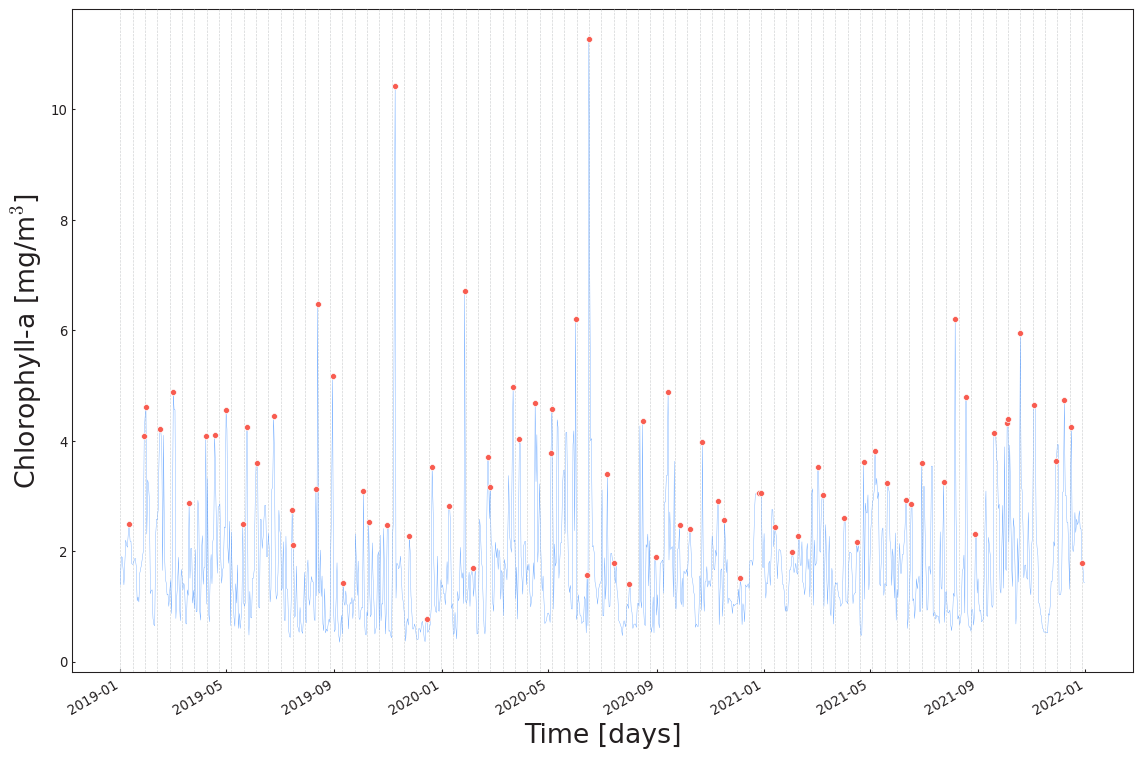

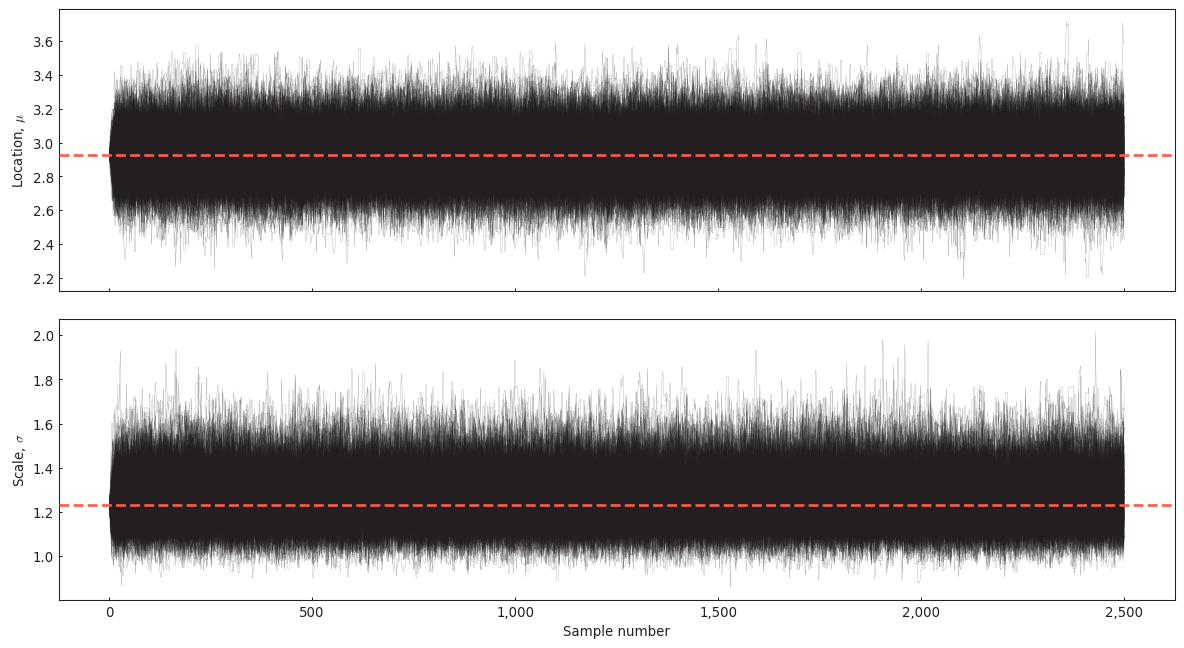

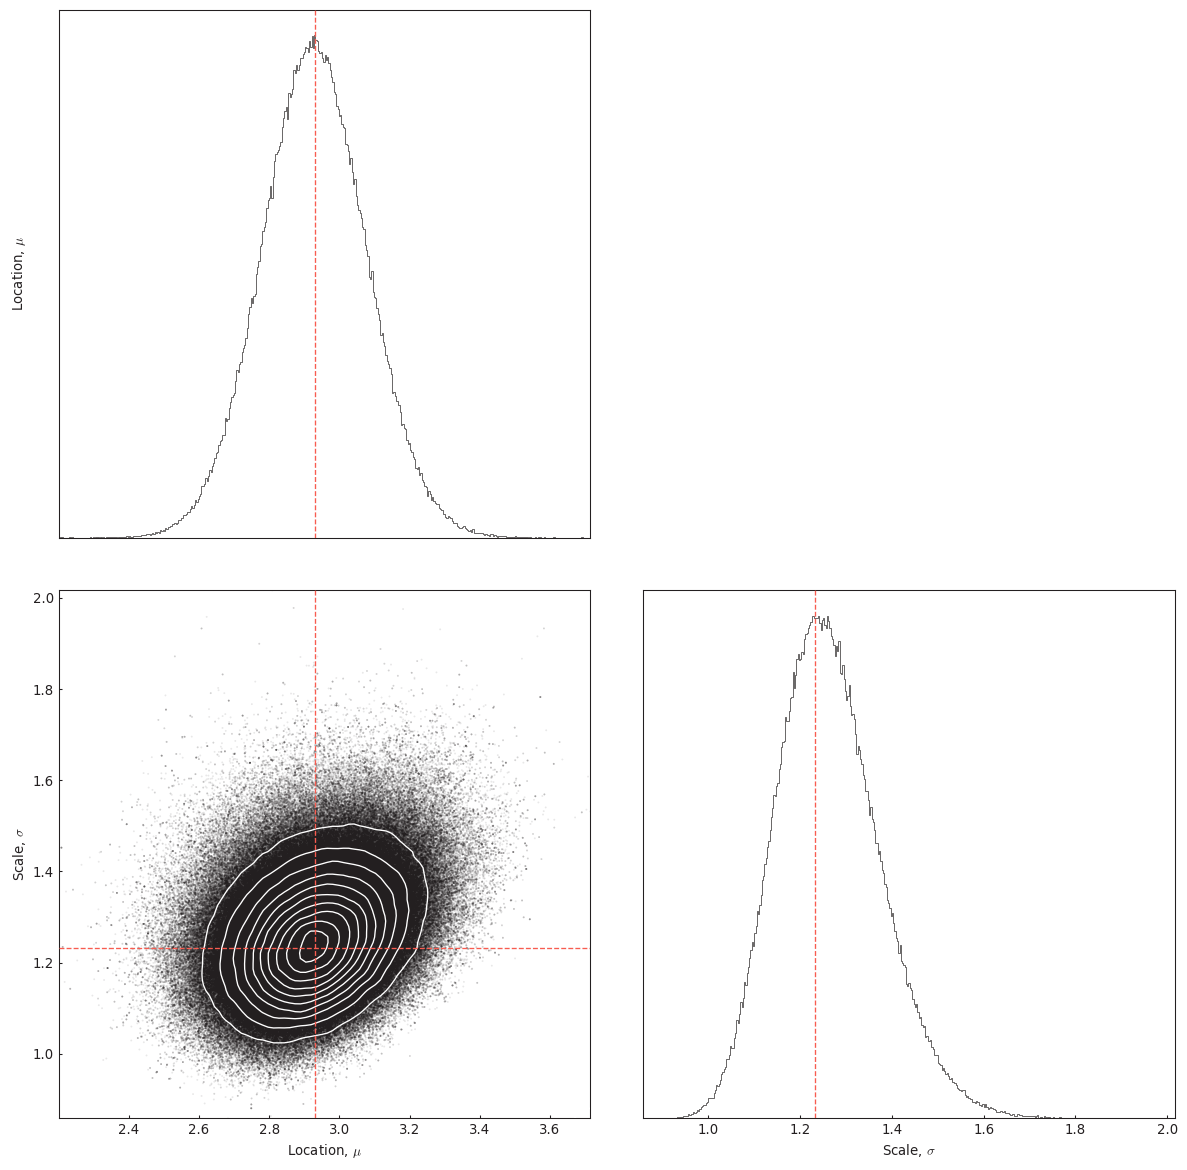

In [30]:
# Fit the model and plot the extremes and MCMC traces
ext_chl_model.fit_and_plot_model()

In [31]:
# Generate and save the summary of block maxima and return periods, and compute return periods for extremes
ext_chl_model.summarize_and_save()

Error summarizing and saving data: unrecognized arguments passed in: n_samples


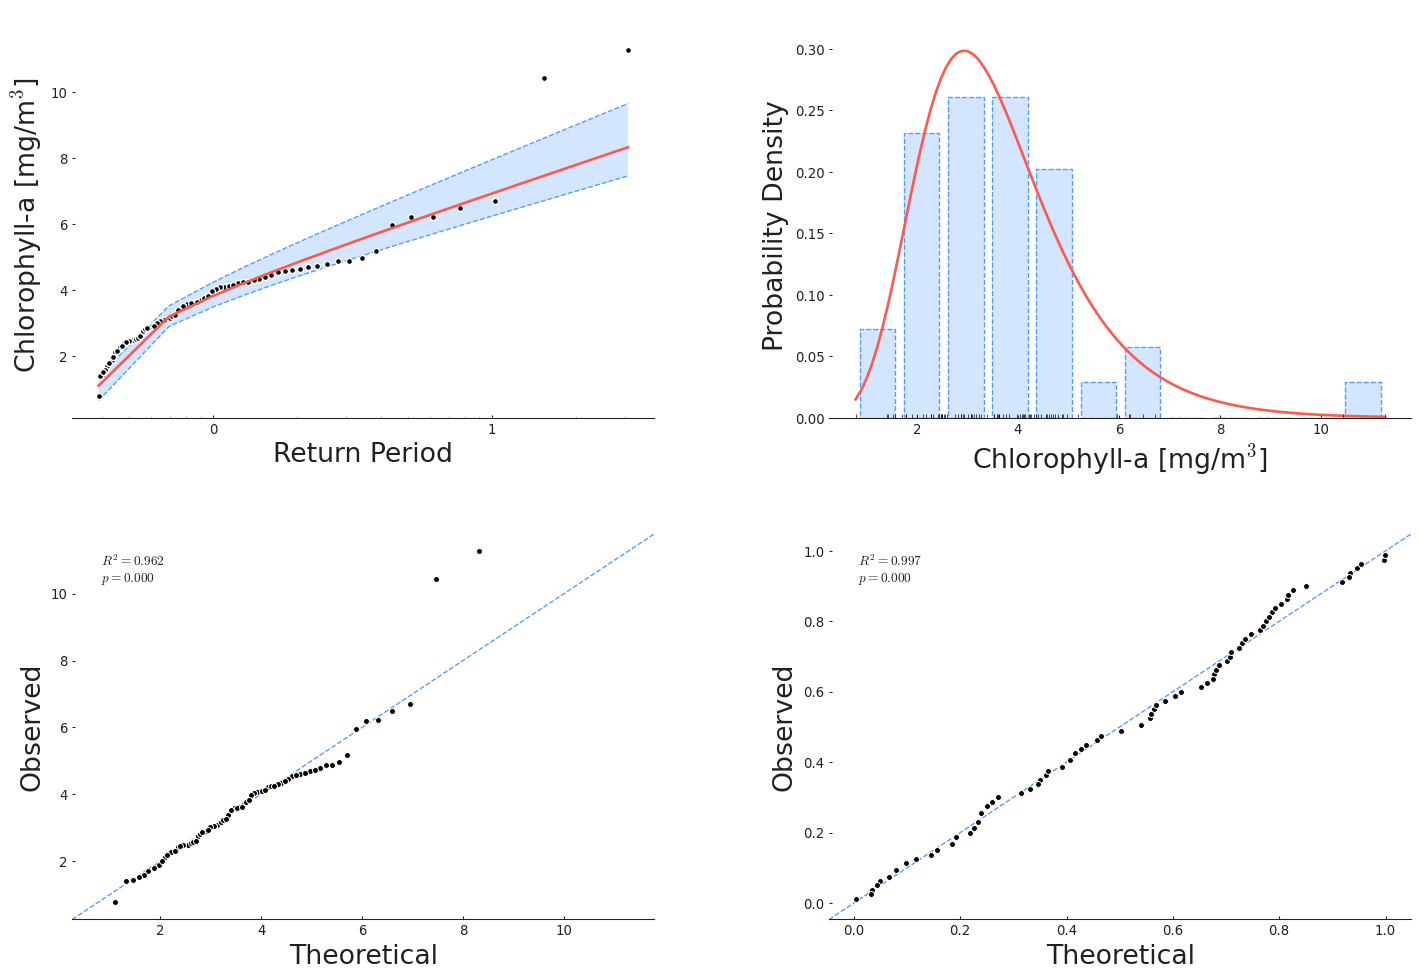

In [32]:
# Plot diagnostic figures for the extreme value analysis
ext_chl_model.plot_diagnostic_figures()

In [33]:
shutup.jk() # SPEAK !!!

# AutoGluon Machine Learning: Multivariate Regression

## Development

### Method

#### AutoGluon Workflow Implementation
We implemented a machine learning workflow using the AutoGluon TabularPredictor to predict the `Chlorophyll_a` concentration from various environmental features. The process involves several key steps: data preprocessing, model training with hyperparameter selection, and model evaluation.

#### Data Preprocessing
The dataset, comprising 877 rows and 9 columns, underwent initial preprocessing to remove unnecessary columns and handle missing values. Feature engineering was automatically conducted by AutoGluon to optimize the dataset for model training. The preprocessing stage resulted in 9 features used for model training.

#### Model Training
We explored multiple models without specifying presets, although AutoGluon recommended using presets like `'best_quality'` for maximizing accuracy. Our training utilized various models, including ensemble methods and neural networks, to predict `Chlorophyll_a` levels, a regression problem inferred by AutoGluon due to the float type and variance of the label column.

In [34]:
class AutoGluonWorkflow:
    """
    This class encapsulates the workflow for training and evaluating a machine learning model
    using AutoGluon's TabularPredictor for a given tabular dataset.
    """

    def __init__(self, data_path, save_path):
        """
        Initializes the workflow with the dataset path and the path to save trained models.

        Parameters:
        - data_path (str): The file path to the dataset.
        - save_path (str): The directory path to save the trained models and their artifacts.
        """
        self.data_path = data_path
        self.save_path = save_path
        self.predictor = None 

    def load_and_prepare_data(self):
        """
        Loads the dataset from the specified path and performs initial preprocessing, such as
        removing unnecessary columns.

        Returns:
        - A pandas DataFrame with the processed dataset or None if an error occurs.
        """
        try:
            data = TabularDataset(self.data_path)
            data.drop(columns='Date', inplace=True)  # Assuming 'Date' column is not needed
            return data
        except Exception as e:
            print(f"Failed to load or preprocess data: {e}")
            return None

    def split_data(self, data):
        """
        Splits the data into training and test sets.

        Parameters:
        - data (pd.DataFrame): The preprocessed dataset.

        Returns:
        - A tuple containing the training and test data as pandas DataFrames.
        """
        try:
            train_size = round(0.8 * len(data))
            train_data = data.sample(train_size, random_state=128)
            test_data = data.drop(train_data.index)
            return train_data, test_data
        except Exception as e:
            print(f"Failed to split data: {e}")
            return None, None

    def train_and_evaluate(self, train_data, test_data):
        """
        Trains a machine learning model using AutoGluon's TabularPredictor on the training data
        and evaluates its performance on the test set. It also calculates and prints feature
        importances.

        Parameters:
        - train_data (pd.DataFrame): The training dataset.
        - test_data (pd.DataFrame): The test dataset.
        """
        try:
            # Training the model
            self.predictor = TabularPredictor(label="Chlorophyll_a", path=self.save_path).fit(train_data)
            
            # Displaying the leaderboard of models
            leaderboard = self.predictor.leaderboard()
            leaderboard.to_csv("../data/devel_leaderboard.csv", index=False)
            print(leaderboard)

            # Evaluating the model on the test set
            y_test = test_data["Chlorophyll_a"]
            test_features = test_data.drop(columns=["Chlorophyll_a"])
            y_pred = self.predictor.predict(test_features)
            metrics = self.predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)

            # Printing evaluation metrics with three decimal precision
            for key, value in metrics.items():
                print(f"{key}: {value:.3f}")

            # Calculating and printing feature importances
            feature_importance = self.predictor.feature_importance(test_data)
            feature_importance.to_csv("../data/devel_features_imp.csv")
            print(feature_importance)
        except Exception as e:
            print(f"Failed to train or evaluate the model: {e}")

    def get_predictor(self):
        """
        Returns the TabularPredictor instance used for training the model.

        Returns:
        - The TabularPredictor instance or None if the predictor is not yet initialized.
        """
        return self.predictor

if __name__ == "__main__":
    ag_workflow = AutoGluonWorkflow("../data/all_data.csv", "../autogluon_models/trained_models")
    data = ag_workflow.load_and_prepare_data()
    if data is not None:
        train_data, test_data = ag_workflow.split_data(data)
        if train_data is not None and test_data is not None:
            ag_workflow.train_and_evaluate(train_data, test_data)
            predictor = ag_workflow.get_predictor()

No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ...
AutoGluon will save models to "../autogluon_models/trained_models"
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Wed Mar  6 19:35:04 UTC 2024
CPU Count:          8
Memory Avail:       27.22 GB / 31.08 GB (87.6%)
Disk Space A

[1000]	valid_set's rmse: 1.04428


	-1.0358	 = Validation score   (-root_mean_squared_error)
	1.2s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ...
	-1.0949	 = Validation score   (-root_mean_squared_error)
	0.65s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-1.1084	 = Validation score   (-root_mean_squared_error)
	0.9s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: CatBoost ...
	-1.0072	 = Validation score   (-root_mean_squared_error)
	1.82s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-1.0026	 = Validation score   (-root_mean_squared_error)
	0.6s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-1.1352	 = Validation score   (-root_mean_squared_error)
	8.95s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: XGBoost ...
	-1.2801	 = Validation score   (-root_mean_squared_error)
	1.02s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting

                  model  score_val              eval_metric  pred_time_val  \
0   WeightedEnsemble_L2  -0.995083  root_mean_squared_error       0.065366   
1         ExtraTreesMSE  -1.002558  root_mean_squared_error       0.056926   
2              CatBoost  -1.007172  root_mean_squared_error       0.001695   
3            LightGBMXT  -1.035817  root_mean_squared_error       0.006406   
4         LightGBMLarge  -1.075390  root_mean_squared_error       0.001606   
5              LightGBM  -1.094944  root_mean_squared_error       0.003624   
6       RandomForestMSE  -1.108373  root_mean_squared_error       0.059021   
7       NeuralNetFastAI  -1.135232  root_mean_squared_error       0.063520   
8        NeuralNetTorch  -1.145887  root_mean_squared_error       0.024649   
9               XGBoost  -1.280130  root_mean_squared_error       0.007978   
10       KNeighborsUnif  -1.304055  root_mean_squared_error       0.019237   
11       KNeighborsDist  -1.328287  root_mean_squared_error     

	0.94s	= Actual runtime (Completed 5 of 5 shuffle sets)


                       importance    stddev   p_value  n  p99_high   p99_low
Temperature              0.071750  0.014505  0.000190  5  0.101615  0.041884
Solar_Radiation          0.061447  0.021620  0.001571  5  0.105962  0.016932
Phosphate                0.047210  0.011034  0.000333  5  0.069929  0.024491
Total_River_Discharge    0.042495  0.009901  0.000329  5  0.062881  0.022109
Salinity                 0.035294  0.008676  0.000405  5  0.053158  0.017430
Silicate                 0.032194  0.013379  0.002883  5  0.059741  0.004647
Dissolved_Oxygen         0.027826  0.005994  0.000243  5  0.040169  0.015484
Nitrate                  0.026418  0.008122  0.000949  5  0.043142  0.009694
Rainfall                -0.020214  0.007463  0.998124  5 -0.004847 -0.035581


/tmp/ipykernel_4339/4238427318.py:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20')


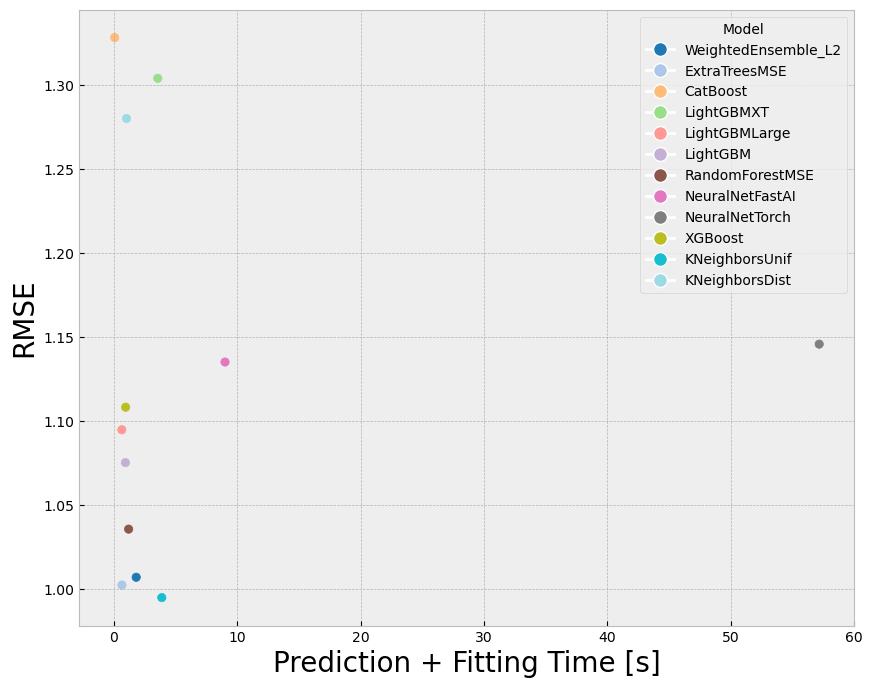

Plot saved successfully to ../figs/fig4.png


In [39]:
from matplotlib.cm import get_cmap

class ModelPerformancePlotter:
    """
    A class to plot the performance of various models based on their RMSE and prediction + fitting times, and save the plot as a PNG file.
    
    Attributes:
        filepath (str): The path to the CSV file containing the model performance data.
        leaderboard (pd.DataFrame): DataFrame to store model performance data.
    """
    
    def __init__(self, filepath):
        """
        Initializes the ModelPerformancePlotter with the path to the data file.
        
        Parameters:
            filepath (str): The path to the CSV file containing the model performance data.
        """
        self.filepath = filepath
        self.leaderboard = None
        
    def load_data(self):
        """
        Loads the model performance data from a CSV file.
        
        Raises:
            FileNotFoundError: If the specified file does not exist.
            pd.errors.EmptyDataError: If the file is empty.
            pd.errors.ParserError: If the file cannot be parsed into a DataFrame.
        """
        try:
            self.leaderboard = pd.read_csv(self.filepath)
        except FileNotFoundError:
            print(f"Error: The file {self.filepath} was not found.")
            raise
        except pd.errors.EmptyDataError:
            print("Error: The file is empty.")
            raise
        except pd.errors.ParserError:
            print("Error: The file could not be parsed.")
            raise

    def preprocess_data(self):
        """
        Processes the loaded data to prepare for plotting.
        
        Calculates the absolute RMSE values and sums the prediction and fitting times.
        Assigns a unique number to each model for coloring purposes in the plot.
        """
        if self.leaderboard is None:
            raise ValueError("Data has not been loaded. Please call load_data() first.")
        
        self.leaderboard['RMSE'] = self.leaderboard['score_val'].abs()
        self.leaderboard['Prediction + Fitting Time [s]'] = self.leaderboard['pred_time_val'] + self.leaderboard['fit_time']
        self.leaderboard['model_num'] = self.leaderboard['model'].astype('category').cat.codes
        
    def plot_and_save_performance(self, filename):
        """
        Plots the model performance showcasing the RMSE against the prediction + fitting times and saves the plot as a PNG file.
        
        Parameters:
            filename (str): The name of the file to save the plot to, including path if necessary.
        """
        if self.leaderboard is None or 'model_num' not in self.leaderboard.columns:
            raise ValueError("Data has not been preprocessed. Please call preprocess_data() first.")
        
        fig, ax = plt.subplots(figsize=(10, 8))
        cmap = get_cmap('tab20')
        norm = plt.Normalize(0, len(self.leaderboard['model'].unique()) - 1)
        
        scatter = ax.scatter(self.leaderboard['Prediction + Fitting Time [s]'], self.leaderboard['RMSE'],
                             c=self.leaderboard['model_num'], cmap=cmap, norm=norm, marker='o')
        
        # Custom legend
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=model, 
                                      markersize=10, markerfacecolor=cmap(norm(i))) 
                           for i, model in enumerate(self.leaderboard['model'].unique())]
        ax.legend(handles=legend_elements, title="Model")
        
        ax.set_xlabel('Prediction + Fitting Time [s]', fontsize=20)
        ax.set_ylabel('RMSE', fontsize=20)
        
        plt.savefig(filename, dpi=450, format='png')
        plt.show()

# Example usage
filepath = '../data/devel_leaderboard.csv'
plot_filename = '../figs/fig4.png'
plotter = ModelPerformancePlotter(filepath)

try:
    plotter.load_data()
    plotter.preprocess_data()
    plotter.plot_and_save_performance(plot_filename)
    print(f"Plot saved successfully to {plot_filename}")
except Exception as e:
    print(f"An error occurred: {e}")

### Results

#### Training Summary
- **AutoGluon Version:** 1.0.0
- **Evaluation Metric:** Root Mean Squared Error (RMSE), with the aim to minimize this value.
- **Best Model:** Weighted Ensemble L2, achieving a validation score (negative RMSE) of -0.9951, indicating a lower error rate compared to individual models.
- **Model Performance:** The ensemble model outperformed individual models such as ExtraTreesMSE, CatBoost, and LightGBMXT, based on the validation score.
- **Feature Importance:** Temperature, Solar Radiation, and Phosphate were identified as the most important features influencing `Chlorophyll_a` concentration.

#### Evaluation Metrics
##### Root Mean Squared Error (RMSE)
$$\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$$

##### Mean Squared Error (MSE)
$$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

##### Mean Absolute Error (MAE)
$$\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$$

##### $R^2$ (Coefficient of Determination)
$$R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \overline{y})^2} $$

##### Pearson Correlation Coefficient
$$r = \frac{n(\sum xy) - (\sum x)(\sum y)}{\sqrt{[n\sum x^2 - (\sum x)^2][n\sum y^2 - (\sum y)^2]}} $$

- **RMSE (Root Mean Squared Error):** -0.868. This value is negative due to AutoGluon's convention; the actual RMSE value is the positive version of this number.
- **MSE (Mean Squared Error):** -0.754.
- **MAE (Mean Absolute Error):** -0.646.
- **R^2 (Coefficient of Determination):** 0.204. Indicates the proportion of the variance in the dependent variable predictable from the independent variables.
- **Pearson Correlation Coefficient:** 0.470. Demonstrates the linear correlation between the predicted and actual values.
- **Median Absolute Error:** -0.515.

### Individual Model Methodologies

#### Extra Trees (Extremely Randomized Trees) - ExtraTreesMSE
Extra Trees builds multiple decision trees to reduce variance by averaging predictions. Unlike other ensemble methods that seek the best split, Extra Trees selects splits randomly, aiming to decrease the model's variance without significantly increasing its bias.

**Equation for Tree Split (MSE as criterion):**

$$S = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_{i,tree})^2 $$

, where $S$ is the split criterion, $N$ the number of samples, $y_i$ the actual value, and $\hat{y}_{i,tree}$ the predicted value by a tree.

#### CatBoost
CatBoost manages categorical features effectively and reduces overfitting through ordered boosting. It provides a gradient boosting framework that focuses on improving speed, accuracy, and stability of the machine learning model.

**Equation for Gradient Boosting:**
$$F_{m}(x) = F_{m-1}(x) + \gamma_m h_m(x)$$

$F_{m}(x)$ is the model's prediction at iteration $m$, $h_m(x)$ the weak learner, and $\gamma_m$ the learning rate.

#### LightGBMXT (Light Gradient Boosting Machine)
LightGBMXT is an efficient implementation that uses Gradient-based One-Side Sampling and Exclusive Feature Bundling to deal with large datasets and high dimensionality, optimizing traditional gradient boosting decision tree algorithms.

**Equation for Gradient-based Decision Tree Boosting:**

$$G_{l} = \sum_{i \in I_{l}} g_{i}, \quad H_{l} = \sum_{i \in I_{l}} h_{i}$$

$G_{l}$ and $H_{l}$ are the gradients and Hessian of the loss function for observations \(i\) in leaf \(l\).

### Ensemble Method: Weighted Ensemble L2

The Weighted Ensemble L2 method optimizes the combination of individual model predictions by assigning weights that reflect their predictive accuracy and importance. This ensemble strategy significantly improves the overall model's performance by leveraging the unique strengths of each component model.

**Equation for Weighted Ensemble Prediction:**
$$\hat{y} = \sum_{i=1}^{N} w_i \cdot \hat{y}_i$$
$N$ represents the number of models, $w_i$ the weight of the $i^{th}$ model, and $\hat{y}_i$ the prediction of the $i^{th}$ model.


### Permutation Feature Importance

Permutation feature importance is a model inspection technique that evaluates the significance of each feature in a predictive model by measuring the change in model performance resulting from the random shuffling of individual feature values. This method provides insights into which features are most important for the model's predictions and is particularly useful for understanding, validating, or explaining a model's behavior. Below is an integrated explanation of the process, equations, and interpretations involved in calculating permutation feature importance.

#### Process Overview

1. **Establish Baseline Performance:** The initial step involves calculating the model's performance on a validation or test set to establish a baseline metric, such as accuracy for classification tasks or Root Mean Squared Error (RMSE) for regression tasks.

2. **Feature Shuffling:** The values of each feature are shuffled individually across all examples in the dataset, breaking the association between the feature and the target outcome. All other features remain unchanged.

3. **Measure Performance Post-Shuffling:** After shuffling a feature, the model's performance metric is recalculated. A decline in performance compared to the baseline indicates the feature's importance.

4. **Repeat for Reliability:** The shuffling and performance measurement steps are repeated multiple times for each feature to mitigate the effects of random variation. This process ensures the reliability of the importance scores.

5. **Compute Feature Importance:** The importance of a feature is quantified by the extent of performance degradation it causes when its values are shuffled.

#### Mathematical Formulation

- **Baseline Performance Equation:**
$$P_{baseline} = f(M, D) $$

, where $P_{baseline}$ denotes the performance of model $M$ on the unshuffled dataset $D$.

- **Shuffled Performance Equation:**
- 
$$P_{\text{shuffle}} = f(M, D_{\text{shuffle}}) $$

, where $P_{shuffle}$ represents the performance of model $M$ on the dataset $D_{shuffle}$, with $D_{shuffle}$ indicating the dataset after a specific feature has been shuffled.

- **Feature Importance Calculation:**
$$I = P_{\text{baseline}} - P_{\text{shuffle}} $$
The importance $I$ of a feature is the difference in performance between the baseline $P_{\text{baseline}}$ and after shuffling $P_{\text{shuffle}}$. A larger difference signifies greater importance.

### Statistical Significance and Interpretation

- **Standard Deviation (stddev):** This measure reflects the variability in the importance scores across multiple shuffling iterations, providing insight into their consistency.

- **P-value:** A statistical measure used to determine the significance of the importance scores. Lower p-values suggest that the observed importance is less likely to be due to chance.

- **Confidence Intervals:** Calculated to offer a range (e.g., 99% confidence interval) within which the true importance score is likely to reside, enhancing confidence in the robustness of the importance evaluation.

### Shuffling Results Interpretation

- **Importance Scores:** Indicate the relative significance of each feature to the model's accuracy. Higher scores point to features that are more crucial for making accurate predictions.

- **Variability and Significance:** The standard deviation and p-value associated with each feature's importance score assess the consistency and statistical significance of its impact on model performance.

- **Confidence Intervals (p99_high, p99_low):** Provide a statistical range that likely contains the true importance score of each feature, underscoring the reliability of the permutation feature importance method.

- The results show that **Temperature**, **Solar Radiation**, and **Phosphate** are among the most important features, as indicated by their higher importance scores and lower p-values, suggesting they significantly affect the model's predictions.
- **Total River Discharge** and **Salinity** also show importance but to a lesser extent.

This method offers a straightforward and model-agnostic way to gauge feature importance, crucial for understanding, validating, or explaining a model's behavior.

### Conclusion
The AutoGluon TabularPredictor efficiently handled the regression problem of predicting `Chlorophyll_a` concentration. The weighted ensemble method proved most effective, demonstrating the importance of ensemble learning in achieving higher accuracy. Further studies could explore the impact of AutoGluon's recommended presets on model performance and accuracy.

## Deployment

In [40]:
# Load previously trained data
new_predictor = TabularPredictor.load("../autogluon_models/trained_models")

# Refit model to test data also for deployment
new_predictor.refit_full() 

# Save final model for deployment
new_predictor.clone_for_deployment('../autogluon_models/final_model_for_deployment')

Refitting models via `predictor.refit_full` using all of the data (combined train and validation)...
	Models trained in this way will have the suffix "_FULL" and have NaN validation score.
	This process is not bound by time_limit, but should take less time than the original `predictor.fit` call.
	To learn more, refer to the `.refit_full` method docstring which explains how "_FULL" models differ from normal models.
Model 'KNeighborsUnif' already has a refit _FULL model: 'KNeighborsUnif_FULL', skipping refit...
Model 'KNeighborsDist' already has a refit _FULL model: 'KNeighborsDist_FULL', skipping refit...
Model 'LightGBMXT' already has a refit _FULL model: 'LightGBMXT_FULL', skipping refit...
Model 'LightGBM' already has a refit _FULL model: 'LightGBM_FULL', skipping refit...
Model 'RandomForestMSE' already has a refit _FULL model: 'RandomForestMSE_FULL', skipping refit...
Model 'CatBoost' already has a refit _FULL model: 'CatBoost_FULL', skipping refit...
Model 'ExtraTreesMSE' already 

'../autogluon_models/final_model_for_deployment'

# Acknowledgements

The author expresses profound gratitude to Iwan P. Anwar for his essential contribution in initiating this study and for the provision of his dissertation data for our analysis. Heartfelt thanks are also extended to Roby Douilly and fellow classmates from GEO256, whose teachings have been instrumental throughout the Spring quarter. Acknowledgment is also made to Andrew J. Ridgwell for his patience and understanding, which facilitated the delay of certain research activities to prioritize the completion of the final project. Additionally, the author is thankful for the financial support provided by the Directorate General of Higher Education, Research, and Technology, Ministry of Education, Culture, Research, and Technology, Republic of Indonesia, under grant No.FITB.PN-1-12-202, and ITB's Research, Community Service and Innovation Program (PPMI-ITB) for the years 2021 and 2022, which supported the data collection and numerical modeling efforts. The data processing and statistical analysis aspects of this study were made possible through the Dean's Distinguished Fellowship at the University of California, Riverside 2023.

# References

1. Anwar, Iwan Pramesti, et al. "Detecting chlorophyll-a concentration and bloom patterns in the coastal area around Indonesia's new capital city (Nusantara) using ocean color reanalysis data". AACL Bioflux 16. 4(2023): 2349 - 2367.
2. E.U. Copernicus Marine Service Information, 2023a Global Ocean Biogeochemistry Analysis and Forecast. Copernicus Marine Service. https://data.marine.copernicus.eu/product/GLOBAL_ANALYSIS_FORECAST_BIO_001_028/description.
3. E.U. Copernicus Marine Service Information, 2023b Global Ocean Colour (Copernicus-GlobColour), Bio-Geo-Chemical, L4 (monthly and interpolated) from Satellite Observations (1997-ongoing). Copernicus Marine Service. https://data.marine.copernicus.eu/product/OCEANCOLOUR_GLO_BGC_L4_MY_009_104/services.
4. Erickson, Nick, et al. "Autogluon-tabular: Robust and accurate automl for structured data." arXiv preprint arXiv:2003.06505 (2020).
5. Harrigan S., Zsoter E., Alfieri L., Prudhomme C., Salamon P., Wetterhall F., Barnard C., Cloke H., Pappenberger F., 2020 GloFAS-ERA5 operational global river discharge reanalysis 1979–present. Earth System Science Data 12(3):2043–2060.
6. Hersbach H., Bell B., Berrisford P., Biavati G., Horányi A., Muñoz S. J., Nicolas J., Peubey C., Radu R., Rozum I., Schepers D., Simmons A., Soci C., Dee D., Thépaut J.-N., 2023 ERA5 hourly data on single levels from 1940 to present. Copernicus Climate Change Service (C3S) Climate Data Store (CDS). https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels.
7. Normile, Dennis. "Indonesia’s utopian new capital may not be as green as it looks." *Science* 375.6580 (2022): 479-480
8.Pusat Database BMKG, 2023 [Online Data Database Center for Meteorology,Climatology and Geophysics Agency]. National Databased Center. https://dataonline.bmkg.go.id/. [In Indonesian].
9. Putri, Mutiara Rachmat, et al. "Observation and numerical modeling of physical oceanography in the Balikpapan Bay, East Kalimantan: Preliminary results." *Depik* 10.2 (2021): 130-135.
   